In [1]:
import pandas as pd
from PIL import Image
import cv2, os, tqdm
import matplotlib.pyplot as plt
import numpy as np
import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, Input, MaxPool2D, Conv2DTranspose, Concatenate, Lambda, BatchNormalization, Activation

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
NUMBER_OF_CHANNELS = 1

IMG_HEIGHT = 128
IMG_WIDTH = 128

KERNEL_SIZE = 3
POOL_SIZE = (2, 2)

UPSCALE_KERNEL_SIZE = 2
UPSCALE_STRIDE_SIZE = 2

FILTERS = 64

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, KERNEL_SIZE, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, KERNEL_SIZE, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def downscale_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    pool = MaxPool2D(POOL_SIZE)(x)
    return [pool, x]

def upscale_block(input_tensor, concat_tensor, num_filters):
    upscale  = Conv2DTranspose(num_filters, UPSCALE_KERNEL_SIZE, UPSCALE_STRIDE_SIZE, padding = "same")(input_tensor)
    new_tensor = Concatenate()([upscale, concat_tensor])
    x = conv_block(new_tensor, num_filters)
    return x

def U_net(input_shape, filters):
    input_tensor = Input(input_shape)
    input_tenosr = Lambda(lambda x : x/255)(input_tensor)
    
    downscale_1 = downscale_block(input_tensor, filters*1)
    downscale_2 = downscale_block(downscale_1[0], filters*2)
    downscale_3 = downscale_block(downscale_2[0], filters*4)
    downscale_4 = downscale_block(downscale_3[0], filters*8)
    
    mid_conv = conv_block(downscale_4[0], filters*16)
    
    upscale_1 = upscale_block(mid_conv, downscale_4[1], filters*8)
    upscale_2 = upscale_block(upscale_1, downscale_3[1], filters*4)
    upscale_3 = upscale_block(upscale_2, downscale_2[1], filters*2)
    upscale_4 = upscale_block(upscale_3, downscale_1[1], filters*1)
    
    output_tensor = Conv2D(1, 1, padding="same", activation="relu")(upscale_4)
    
    model = Model(inputs = input_tensor, outputs = output_tensor)
    return model

In [3]:
model = U_net((IMG_HEIGHT, IMG_HEIGHT, NUMBER_OF_CHANNELS), 32)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.02), loss='binary_crossentropy', metrics=['accuracy'])

In [4]:
images = os.listdir("../input/lung-mask-image-dataset/ChestXray/train/image")
masks = os.listdir("../input/lung-mask-image-dataset/ChestXray/train/mask")

v_images = os.listdir("../input/lung-mask-image-dataset/ChestXray/val/image")
v_masks = os.listdir("../input/lung-mask-image-dataset/ChestXray/val/mask")

In [5]:
def make_dataset(validation=False):
  x = []
  y = []
  if(validation):
    for i,(image,mask) in enumerate(zip(v_images[:10000],v_masks[:10000])):
      print("\r"+str(i)+"/"+str(len(v_images)),end="")

      image = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/val/image",image)).convert('L')
      mask = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/val/mask",mask)).convert('L')

      image = np.asarray(image.resize((128,128)))/255
      mask = np.asarray(mask.resize((128,128)))/255

      x.append(image)
      y.append(mask)
  else:
    for i,(image,mask) in enumerate(zip(images[:10000],masks[:10000])):
      print("\r"+str(i)+"/"+str(len(images)),end="")
      
      image = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/train/image",image)).convert('L')
      mask = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/train/mask",mask)).convert('L')

      image = np.asarray(image.resize((128,128)))/255.
      mask = np.asarray(mask.resize((128,128)))/255.

      x.append(image)
      y.append(mask)

  return np.array(x),np.array(y)

In [6]:
x,y = make_dataset()
v_x,v_y = make_dataset(True)

2116/21172

In [7]:
x,y = np.expand_dims(x,axis=-1),np.expand_dims(y,axis=-1)
v_x,v_y = np.expand_dims(v_x,axis=-1),np.expand_dims(v_y,axis=-1)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1

image_generator = image_datagen.flow(
    x,
    batch_size=64,
    seed=seed)

mask_generator = mask_datagen.flow(
    y,
    batch_size=64,
    seed=seed)

train_generator = zip(image_generator, mask_generator)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_test_datagen = ImageDataGenerator()
mask_test_datagen = ImageDataGenerator()

seed = 1

image_test_generator = image_test_datagen.flow(
    v_x,
    batch_size=64,
    seed=seed)

mask_test_generator = mask_test_datagen.flow(
    v_y,
    batch_size=64,
    seed=seed)

valid_generator = zip(image_test_generator, mask_test_generator)

In [10]:
model_history = model.fit(x,y,epochs=25,validation_split=0.2)

Epoch 1/25
250/250 [==============================] - 48s 100ms/step - loss: 0.6556 - accuracy: 0.7744 - val_loss: 0.3804 - val_accuracy: 0.8174
Epoch 2/25
250/250 [==============================] - 24s 97ms/step - loss: 0.3082 - accuracy: 0.8401 - val_loss: 0.3075 - val_accuracy: 0.8425
Epoch 3/25
250/250 [==============================] - 24s 97ms/step - loss: 0.3012 - accuracy: 0.8458 - val_loss: 0.3500 - val_accuracy: 0.8402
Epoch 4/25
250/250 [==============================] - 23s 94ms/step - loss: 0.3101 - accuracy: 0.8371 - val_loss: 0.3595 - val_accuracy: 0.8337
Epoch 5/25
250/250 [==============================] - 24s 97ms/step - loss: 0.3085 - accuracy: 0.8388 - val_loss: 0.3501 - val_accuracy: 0.8430
Epoch 6/25
250/250 [==============================] - 24s 97ms/step - loss: 0.3032 - accuracy: 0.8463 - val_loss: 0.3026 - val_accuracy: 0.8447
Epoch 7/25
250/250 [==============================] - 23s 94ms/step - loss: 0.3021 - accuracy: 0.8427 - val_loss: 0.2910 - val_accuracy

1/1 [==============================] - 0s 20ms/step


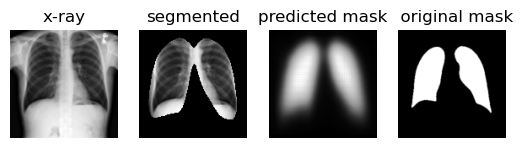

In [16]:
i = np.random.randint(0,len(v_x)-1)

original = x[i].copy()
original_mask = y[i].copy()

mask = model.predict(np.expand_dims(original,axis=0))


segmented = np.squeeze(original).copy()
segmented[np.squeeze(mask)<0.2] = 0

plt.subplot(1,4,1)
plt.imshow(np.squeeze(original),cmap="gray")
plt.title("x-ray")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(segmented,cmap="gray")
plt.title("segmented")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(np.squeeze(mask[0]),cmap="gray")
plt.title("predicted mask")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(np.squeeze(original_mask),cmap="gray")
plt.title("  original mask")
plt.axis("off")


plt.show()